In [33]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"

In [34]:
#Compare the OECD life satisfaction data to the IMF GDP per capita data
#Checking whether money brings higher life satisfaction or not

In [35]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    # Set OECD data
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

    # Set GDP per capita data
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)

    # Set overall data set
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)

    # Remove Luxembourg (it's just a rich small country)   
    remove_indices = [35]
    keep_indices = list(set(range(36)) - set(remove_indices))

    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

In [36]:
import os
datapath = os.path.join("datasets", "lifesat", "")

# Preparing the graph
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [37]:
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/L1FE0FJ4Y/Life_Satisfaction_Linear_Reg/master/"
os.makedirs(datapath, exist_ok=True)
for filename in ("oecd_bli_2015.csv", "gdp_per_capita.csv"):
    print("Downloading", filename)
    url = DOWNLOAD_ROOT + "lifesat/" + filename
    urllib.request.urlretrieve(url, datapath + filename)

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

# Load datas
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Pick the linear model
l_model = sklearn.linear_model.LinearRegression()

# Prepare datas
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Check the U.S. data
country_stats[["GDP per capita", 'Life satisfaction']].loc["United States"]

# Train the model
l_model.fit(X, y)

t0, t1 = l_model.intercept_[0], l_model.coef_[0][0]


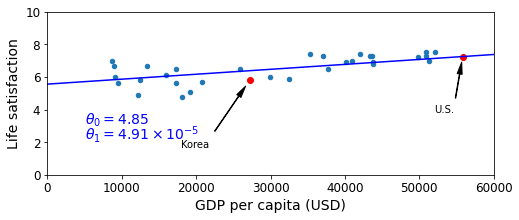

In [42]:
# Visualize data
def visualization(size, intercept, coef, compare_gdp=False, compare_lifesat=False):
    if type(size) is tuple:
        country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=size)
        plt.xlabel("GDP per capita (USD)")
        plt.axis([0, 60000, 0, 10])

        position_text = { "Korea": (18000, 1.7),
                        "United States": (52000, 3.8)}
        for country, pos in position_text.items():
            pos_x, pos_y = country_stats.loc[country]
            country = "U.S." if country == "United States" else country
            plt.annotate(country, xy=(pos_x, pos_y), xytext=pos,
                    arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
            plt.plot(pos_x, pos_y, "ro")

        X=np.linspace(0, 60000, 1000)
        plt.plot(X, intercept + coef*X, "b")
        plt.text(5000, 3.1, r"$\theta_0 = 4.85$", fontsize=14, color="b")
        plt.text(5000, 2.2, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")

        if compare_gdp and compare_lifesat:
            plt.plot([compare_gdp, compare_gdp], [0, compare_lifesat], "r--")
            plt.text(25000, 5.0, r"Prediction = 5.96", fontsize=14, color="b")
            plt.plot(compare_gdp, compare_lifesat, "ro")

        plt.show()

visualization((8,3), t0, t1)

1700


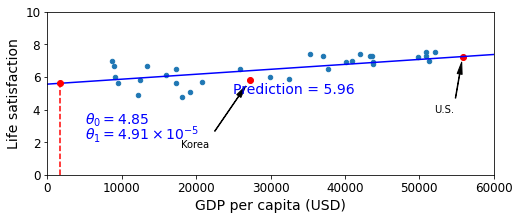

In [43]:
# Predict for North Korea
north_korea_gdp_per_capita = 1700 # North Korea GDP per capita :O wow
print(north_korea_gdp_per_capita)
north_korea_predicted_life_satisfaction = l_model.predict([[north_korea_gdp_per_capita]])[0][0]

visualization((8,3), t0, t1, north_korea_gdp_per_capita, north_korea_predicted_life_satisfaction)

In [44]:
# Seems like richer the country becomes, happiness increases as well (not a lot thoe)
# Maybe North Koreans are as happy as I am

In [45]:
# K-nearest neighbor mode
import sklearn.neighbors

# 3 nearest
k_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors = 3)

# Train the model
k_model.fit(X,y)

# Predict for North Korea
X_new = [[1700]]  # North Korea GDP per capita :O wow
print(k_model.predict(X_new))

[[6.56666667]]
